**Preface:** smarter people have developed SymPy and it appears to work well with my prior testings, generating the expected results, without their contribution I would have not been able to meticulously calculate the complex matrices that describe the robotic arm chosen for this project. Give them a like: [SymPy Docs](https://docs.sympy.org/latest/index.html)!

In [1]:
%matplotlib widget

import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, make_interp_spline, SmoothBivariateSpline
from sympy import (Symbol, Matrix, cos, sin, pi, Eq, pprint, print_latex, MatMul, trigsimp, transpose)
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Forward Kinematics

In this section, we generate the forward kinematics symbolically; we did not perform the  as the larger 

In [2]:
def transformation_matrix(a, alpha, d, theta):
    return Matrix([
        [cos(theta), -sin(theta) * cos(alpha), sin(theta) * sin(alpha), a * cos(theta)],
        [sin(theta), cos(theta) * cos(alpha), -cos(theta) * sin(alpha), a * sin(theta)],
        [0, sin(alpha), cos(alpha), d],
        [0, 0, 0, 1]
    ])

In [3]:
display(transformation_matrix(Symbol('a_n'), Symbol('alpha_n'), Symbol('d_n'), Symbol('theta_n')))

Matrix([
[cos(theta_n), -sin(theta_n)*cos(alpha_n),  sin(alpha_n)*sin(theta_n), a_n*cos(theta_n)],
[sin(theta_n),  cos(alpha_n)*cos(theta_n), -sin(alpha_n)*cos(theta_n), a_n*sin(theta_n)],
[           0,               sin(alpha_n),               cos(alpha_n),              d_n],
[           0,                          0,                          0,                1]])

In [4]:
n_joints = 8

# Define a's
a = [0 for _ in range(n_joints)]
a[1] = Symbol("a_2")
print(f"a = {a}")

# Define alphas
alpha = [pi/2 for _ in range(n_joints)]
alpha[1] = alpha[-1] = 0
alpha[3] *= -1
alpha[-2] = alpha[3]
print(f"alpha = {alpha}")

# Define d's
d = [Symbol(f"d_{i}") for i in range(1, n_joints+1)]
d[1] = d[2] = d[-3] = d[-2] = 0
print(f"d = {d}")

# define thetas
theta = [Symbol(f"theta_{i}^*") for i in range(1, n_joints+1)]
theta[0] += pi/2
theta[2] += pi/2
theta[-3] += pi/2
print(f"theta = {theta}")

a = [0, a_2, 0, 0, 0, 0, 0, 0]
alpha = [pi/2, 0, pi/2, -pi/2, pi/2, pi/2, -pi/2, 0]
d = [d_1, 0, 0, d_4, d_5, 0, 0, d_8]
theta = [theta_1^* + pi/2, theta_2^*, theta_3^* + pi/2, theta_4^*, theta_5^*, theta_6^* + pi/2, theta_7^*, theta_8^*]


In [5]:
T = []
T_exps = []
for i in range(0, n_joints):
    matrix_exp = Symbol(f"^{i}T_{i+1}")
    T.append(transformation_matrix(a[i], alpha[i], d[i], theta[i]))
    eq = Eq(matrix_exp, T[i], evaluate=False)
    T_exps.append(eq)
    display(eq)
    # print_latex(eq)

Eq(^0T_1, Matrix([
[-sin(theta_1^*), 0, cos(theta_1^*),   0],
[ cos(theta_1^*), 0, sin(theta_1^*),   0],
[              0, 1,              0, d_1],
[              0, 0,              0,   1]]))

Eq(^1T_2, Matrix([
[cos(theta_2^*), -sin(theta_2^*), 0, a_2*cos(theta_2^*)],
[sin(theta_2^*),  cos(theta_2^*), 0, a_2*sin(theta_2^*)],
[             0,               0, 1,                  0],
[             0,               0, 0,                  1]]))

Eq(^2T_3, Matrix([
[-sin(theta_3^*), 0, cos(theta_3^*), 0],
[ cos(theta_3^*), 0, sin(theta_3^*), 0],
[              0, 1,              0, 0],
[              0, 0,              0, 1]]))

Eq(^3T_4, Matrix([
[cos(theta_4^*),  0, -sin(theta_4^*),   0],
[sin(theta_4^*),  0,  cos(theta_4^*),   0],
[             0, -1,               0, d_4],
[             0,  0,               0,   1]]))

Eq(^4T_5, Matrix([
[cos(theta_5^*), 0,  sin(theta_5^*),   0],
[sin(theta_5^*), 0, -cos(theta_5^*),   0],
[             0, 1,               0, d_5],
[             0, 0,               0,   1]]))

Eq(^5T_6, Matrix([
[-sin(theta_6^*), 0, cos(theta_6^*), 0],
[ cos(theta_6^*), 0, sin(theta_6^*), 0],
[              0, 1,              0, 0],
[              0, 0,              0, 1]]))

Eq(^6T_7, Matrix([
[cos(theta_7^*),  0, -sin(theta_7^*), 0],
[sin(theta_7^*),  0,  cos(theta_7^*), 0],
[             0, -1,               0, 0],
[             0,  0,               0, 1]]))

Eq(^7T_8, Matrix([
[cos(theta_8^*), -sin(theta_8^*), 0,   0],
[sin(theta_8^*),  cos(theta_8^*), 0,   0],
[             0,               0, 1, d_8],
[             0,               0, 0,   1]]))

## Transformation Matrix
The transformation matrix is large, but shows us how the pose of the arm changes relative to the angles of the joints.

In [6]:
T_08 = trigsimp(MatMul(*T, evaluate=True))
display(Eq(Symbol("^0T_8"), T_08, evaluate=False))

Eq(^0T_8, Matrix([
[((-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(theta_6^*) + (-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))*cos(theta_6^*))*cos(theta_7^*) + ((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*sin(theta_5^*) - sin(theta_1^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(theta_7^*))*cos(theta_8^*) + (-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*cos(theta_6^*) - (-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))*sin(theta_6^*))*sin(theta_8^*), -((-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* +

## Translation Matrix
The following is the translation matrix portion of the Transformation Matrix, showing the position relative to angle.

In [7]:
t = T_08[:-1, -1]
display(Eq(Symbol("t"), t, evaluate=False))

Eq(t, Matrix([
[-a_2*sin(theta_1^*)*cos(theta_2^*) - d_4*sin(theta_1^*)*cos(theta_2^* + theta_3^*) + d_5*(-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*)) + d_8*(-(-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(theta_6^*) + (-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))*cos(theta_6^*))*sin(theta_7^*) + ((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*sin(theta_5^*) - sin(theta_1^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*))*cos(theta_7^*))],
[   a_2*cos(theta_1^*)*cos(theta_2^*) + d_4*cos(theta_1^*)*cos(theta_2^* + theta_3^*) + d_5*(sin(theta_1^*)*cos(theta_4^*) + sin(theta_4^*)*sin(theta_2^* + theta_3^*)*cos(theta_1^*)) + d_8*(-(-((sin(theta_1^*)*sin(theta_4^*) - sin(theta_2^* + theta_3^*)*cos(theta_1^*)*cos(theta_4^*))*cos(theta_5^*)

## Rotation Matrix

Similarly, the following rotation matrix of the Transformation Matrix describes - well - the rotation!

In [8]:
R = T_08[:-1,:-1]
display(Eq(Symbol("R"), R, evaluate=False))

Eq(R, Matrix([
[((-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(theta_6^*) + (-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))*cos(theta_6^*))*cos(theta_7^*) + ((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*sin(theta_5^*) - sin(theta_1^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(theta_7^*))*cos(theta_8^*) + (-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*cos(theta_6^*) - (-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))*sin(theta_6^*))*sin(theta_8^*), -((-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + the

# Jacobian
In this section we derive the full Jacobain of the system. The system can be derived through $J = \begin{bmatrix}J_v \\ J_\omega\end{bmatrix}$ where $J_v$ represents the linear Jacobian and $J_\omega$ is the angular Jacobian.

## Linear Jacobian
The linear Jacobian is $J_v \in R^{3 \times 8}$. It can be computed by computing the partial differentials of the translation matrix $t$ w.r.t. the workspace variables $q$.

$$ J_v = \begin{bmatrix} 
\dfrac{\partial t_x}{\partial q_1} & \dfrac{\partial t_x}{\partial q_2} & ... & \dfrac{\partial t_x}{\partial q_8} \\
\dfrac{\partial t_y}{\partial q_1} & \dfrac{\partial t_y}{\partial q_2} & ... & \dfrac{\partial t_y}{\partial q_8} \\
\dfrac{\partial t_z}{\partial q_1} & \dfrac{\partial t_z}{\partial q_2} & ... & \dfrac{\partial t_z}{\partial q_8} \\
\end{bmatrix} $$

In our case, our workspace variable $q_i = \theta^*_i$ as all our actuating joints are revolute.

In [9]:
# Define q as workspace variables (could just reuse thetas, but for clarity I won't)
q = Matrix([Symbol(f"theta_{i}^*") for i in range(1, n_joints+1)])
q.T

Matrix([[theta_1^*, theta_2^*, theta_3^*, theta_4^*, theta_5^*, theta_6^*, theta_7^*, theta_8^*]])

In [10]:
J_linear = t.jacobian(q)
display(Eq(Symbol("J_v"), J_linear, evaluate=False))

Eq(J_v, Matrix([
[-a_2*cos(theta_1^*)*cos(theta_2^*) - d_4*cos(theta_1^*)*cos(theta_2^* + theta_3^*) + d_5*(-sin(theta_1^*)*cos(theta_4^*) - sin(theta_4^*)*sin(theta_2^* + theta_3^*)*cos(theta_1^*)) + d_8*(-(-((-sin(theta_1^*)*sin(theta_4^*) + sin(theta_2^* + theta_3^*)*cos(theta_1^*)*cos(theta_4^*))*cos(theta_5^*) + sin(theta_5^*)*cos(theta_1^*)*cos(theta_2^* + theta_3^*))*sin(theta_6^*) + (-sin(theta_1^*)*cos(theta_4^*) - sin(theta_4^*)*sin(theta_2^* + theta_3^*)*cos(theta_1^*))*cos(theta_6^*))*sin(theta_7^*) + ((-sin(theta_1^*)*sin(theta_4^*) + sin(theta_2^* + theta_3^*)*cos(theta_1^*)*cos(theta_4^*))*sin(theta_5^*) - cos(theta_1^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*))*cos(theta_7^*)),  a_2*sin(theta_1^*)*sin(theta_2^*) + d_4*sin(theta_1^*)*sin(theta_2^* + theta_3^*) - d_5*sin(theta_1^*)*sin(theta_4^*)*cos(theta_2^* + theta_3^*) + d_8*(-(-(-sin(theta_1^*)*sin(theta_5^*)*sin(theta_2^* + theta_3^*) + sin(theta_1^*)*cos(theta_4^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(th

## Angular Jacobian

The angular Jacobian $J_\omega \in R^{3,8}$. It can be computed by inspecting the axes of rotations (z-axis): $^{0}R^z_{n-1}$ of the rotational matrix. We get $J_\omega = \begin{bmatrix}\rho_1 ^0R^z_0 & \rho_1 ^0R^z_1 & ... & \rho_n ^0R^z_{n-1}\end{bmatrix}$, with $\rho_i = 1 \; \forall i$ since all the joints are revolute.

In [11]:
J_angular = Matrix([1,1,1]) # 0R0 is just identity

for i in range(1, n_joints):
    # Not super efficient, but it'll do
    matrix_exp = Symbol(f"^{0}T_{i}")
    output = trigsimp(MatMul(*T[0:i], evaluate=True))
    eq = Eq(matrix_exp, output, evaluate=False)
    display(eq)
    J_angular = J_angular.row_join(output[:-1, 2])

Eq(^0T_1, Matrix([
[-sin(theta_1^*), 0, cos(theta_1^*),   0],
[ cos(theta_1^*), 0, sin(theta_1^*),   0],
[              0, 1,              0, d_1],
[              0, 0,              0,   1]]))

Eq(^0T_2, Matrix([
[-sin(theta_1^*)*cos(theta_2^*),  sin(theta_1^*)*sin(theta_2^*), cos(theta_1^*), -a_2*sin(theta_1^*)*cos(theta_2^*)],
[ cos(theta_1^*)*cos(theta_2^*), -sin(theta_2^*)*cos(theta_1^*), sin(theta_1^*),  a_2*cos(theta_1^*)*cos(theta_2^*)],
[                sin(theta_2^*),                 cos(theta_2^*),              0,           a_2*sin(theta_2^*) + d_1],
[                             0,                              0,              0,                                  1]]))

Eq(^0T_3, Matrix([
[ sin(theta_1^*)*sin(theta_2^* + theta_3^*), cos(theta_1^*), -sin(theta_1^*)*cos(theta_2^* + theta_3^*), -a_2*sin(theta_1^*)*cos(theta_2^*)],
[-sin(theta_2^* + theta_3^*)*cos(theta_1^*), sin(theta_1^*),  cos(theta_1^*)*cos(theta_2^* + theta_3^*),  a_2*cos(theta_1^*)*cos(theta_2^*)],
[                cos(theta_2^* + theta_3^*),              0,                 sin(theta_2^* + theta_3^*),           a_2*sin(theta_2^*) + d_1],
[                                         0,              0,                                          0,                                  1]]))

Eq(^0T_4, Matrix([
[sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*),  sin(theta_1^*)*cos(theta_2^* + theta_3^*), -sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*), -(a_2*cos(theta_2^*) + d_4*cos(theta_2^* + theta_3^*))*sin(theta_1^*)],
[sin(theta_1^*)*sin(theta_4^*) - sin(theta_2^* + theta_3^*)*cos(theta_1^*)*cos(theta_4^*), -cos(theta_1^*)*cos(theta_2^* + theta_3^*),  sin(theta_1^*)*cos(theta_4^*) + sin(theta_4^*)*sin(theta_2^* + theta_3^*)*cos(theta_1^*),  (a_2*cos(theta_2^*) + d_4*cos(theta_2^* + theta_3^*))*cos(theta_1^*)],
[                                               cos(theta_4^*)*cos(theta_2^* + theta_3^*),                -sin(theta_2^* + theta_3^*),                                                -sin(theta_4^*)*cos(theta_2^* + theta_3^*),             a_2*sin(theta_2^*) + d_1 + d_4*sin(theta_2^* + theta_3^*)],
[                                                                                      

Eq(^0T_5, Matrix([
[(sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*), -sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*), (sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*sin(theta_5^*) - sin(theta_1^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*), -a_2*sin(theta_1^*)*cos(theta_2^*) - d_4*sin(theta_1^*)*cos(theta_2^* + theta_3^*) + d_5*(-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))],
[(sin(theta_1^*)*sin(theta_4^*) - sin(theta_2^* + theta_3^*)*cos(theta_1^*)*cos(theta_4^*))*cos(theta_5^*) - sin(theta_5^*)*cos(theta_1^*)*cos(theta_2^* + theta_3^*),  sin(theta_1^*)*cos(theta_4^*) + sin(theta_4^*)*sin(theta_2^* + theta_3^*)*cos(theta_1^*), (sin(theta_1^*)*sin(theta_4^*) - sin(theta_2^* + theta_3^*)*cos(theta_1^*)*cos(theta_4^*))*sin(theta_5^*) + cos(thet

Eq(^0T_6, Matrix([
[-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(theta_6^*) + (-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))*cos(theta_6^*), (sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*sin(theta_5^*) - sin(theta_1^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*), ((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*cos(theta_6^*) + (-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))*sin(theta_6^*), -a_2*sin(theta_1^*)*cos(theta_2^*) - d_4*sin(theta_1^*)*cos(theta_2^* + theta_3^*) + d_5*(-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))],
[ -((sin(theta_1^*)*sin(theta_4^*) - sin(theta

Eq(^0T_7, Matrix([
[(-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(theta_6^*) + (-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))*cos(theta_6^*))*cos(theta_7^*) + ((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*sin(theta_5^*) - sin(theta_1^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(theta_7^*), -((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*cos(theta_6^*) - (-sin(theta_1^*)*sin(theta_4^*)*sin(theta_2^* + theta_3^*) + cos(theta_1^*)*cos(theta_4^*))*sin(theta_6^*), -(-((sin(theta_1^*)*sin(theta_2^* + theta_3^*)*cos(theta_4^*) + sin(theta_4^*)*cos(theta_1^*))*cos(theta_5^*) + sin(theta_1^*)*sin(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(theta_6^*) + (-sin(

# Final Jacobian
Putting this together, we get the final Jacobian:

In [12]:
J = J_linear.copy()
J = J.col_join(J_angular)
display(Eq(Symbol("J"), J, evaluate=False))

Eq(J, Matrix([
[-a_2*cos(theta_1^*)*cos(theta_2^*) - d_4*cos(theta_1^*)*cos(theta_2^* + theta_3^*) + d_5*(-sin(theta_1^*)*cos(theta_4^*) - sin(theta_4^*)*sin(theta_2^* + theta_3^*)*cos(theta_1^*)) + d_8*(-(-((-sin(theta_1^*)*sin(theta_4^*) + sin(theta_2^* + theta_3^*)*cos(theta_1^*)*cos(theta_4^*))*cos(theta_5^*) + sin(theta_5^*)*cos(theta_1^*)*cos(theta_2^* + theta_3^*))*sin(theta_6^*) + (-sin(theta_1^*)*cos(theta_4^*) - sin(theta_4^*)*sin(theta_2^* + theta_3^*)*cos(theta_1^*))*cos(theta_6^*))*sin(theta_7^*) + ((-sin(theta_1^*)*sin(theta_4^*) + sin(theta_2^* + theta_3^*)*cos(theta_1^*)*cos(theta_4^*))*sin(theta_5^*) - cos(theta_1^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*))*cos(theta_7^*)),  a_2*sin(theta_1^*)*sin(theta_2^*) + d_4*sin(theta_1^*)*sin(theta_2^* + theta_3^*) - d_5*sin(theta_1^*)*sin(theta_4^*)*cos(theta_2^* + theta_3^*) + d_8*(-(-(-sin(theta_1^*)*sin(theta_5^*)*sin(theta_2^* + theta_3^*) + sin(theta_1^*)*cos(theta_4^*)*cos(theta_5^*)*cos(theta_2^* + theta_3^*))*sin(thet

In [13]:
print(J.shape)

(6, 8)


# Trajectory Simulation

In this section, we take the Forward Kinematics & Jacobian generated in the previous section and use them to generate some simulations.

In [14]:
import numpy as np
from scipy.interpolate import CubicSpline

In [15]:
# Some helper functions
def get_pos(T_mat):
    return np.array(T_mat[:-1, -1], dtype=float).reshape(-1)
    
def get_rot(T_mat):
    return np.array(T_mat[:-1,:-1], dtype=float).reshape(-1)

def manipulability(J):
    return np.sqrt(np.linalg.det(J @ J.T))

In [16]:
"""
def linear_function_3d(point1, point2):
    # Unpack the points
    x1, y1, z1 = point1
    x2, y2, z2 = point2

    # Define the parametric equations for x, y, z
    def linear_3d(t):
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        z = z1 + t * (z2 - z1)
        return (x, y, z)

    return linear_3d

# Example points in 3D space with float values
point1_3d = (0.6, 0.7, 2)
point2_3d = (0.6, 1.3, 2)

# Get the linear function defined by the two 3D points
f_linear_3d = linear_function_3d(point1_3d, point2_3d)

# Test the linear function with some values of t (float)
t_values = [0.0, 0.25, 0.5, 0.75, 1.0]
for t in t_values:
    a = f_linear_3d(ts_2)
    print(a)
    #print(f"t = {t}, (x, y, z) = ({x_val}, {y_val}, {z_val})")
    """

'\ndef linear_function_3d(point1, point2):\n    # Unpack the points\n    x1, y1, z1 = point1\n    x2, y2, z2 = point2\n\n    # Define the parametric equations for x, y, z\n    def linear_3d(t):\n        x = x1 + t * (x2 - x1)\n        y = y1 + t * (y2 - y1)\n        z = z1 + t * (z2 - z1)\n        return (x, y, z)\n\n    return linear_3d\n\n# Example points in 3D space with float values\npoint1_3d = (0.6, 0.7, 2)\npoint2_3d = (0.6, 1.3, 2)\n\n# Get the linear function defined by the two 3D points\nf_linear_3d = linear_function_3d(point1_3d, point2_3d)\n\n# Test the linear function with some values of t (float)\nt_values = [0.0, 0.25, 0.5, 0.75, 1.0]\nfor t in t_values:\n    a = f_linear_3d(ts_2)\n    print(a)\n    #print(f"t = {t}, (x, y, z) = ({x_val}, {y_val}, {z_val})")\n    '

In [17]:

#print(end_traj_1)
#end_traj_1 = [0.6, 0.7, 2]
#print(normal)

In [69]:
# Set rng seed
np.random.seed(415)

# Time
t_start = 0
t_end = 10
t_end_1 = int(0.8*t_end)

dt = 0.1
ts_1 = np.linspace(t_start, t_end_1, int((t_end_1-t_start)/dt +1))
#print(ts_1)
ts_2 = np.linspace(t_end_1 + dt, t_end, int((t_end-t_end_1)/dt))
#print(ts_2.shape)
ts = np.concatenate([ts_1, ts_2])
#print(ts)

#boundary of virtual wall + upper limb
xrec = [0.2, 1, 1, 0.2, 0.2]
yrec = [1, 1, 1, 1, 1]
zrec = [-10, -10, 3, 3, -10]

vec1 = np.array([xrec[1]-xrec[0], yrec[1]-yrec[0], zrec[1]-zrec[0]])
vec2 = np.array([xrec[2]-xrec[0], yrec[2]-yrec[0], zrec[2]-zrec[0]])

#find normal direction of the wall
normal = np.cross(vec1, vec2)/np.linalg.norm(np.cross(vec1, vec2))
init_pos = np.array([0.5,-0.3,1.3])
target_pos = np.array([0.6, 1.3, 2])
vec = init_pos - np.array([xrec[0], yrec[0], zrec[0]])
if(np.dot(normal, vec) < 0):
    normal *= -1

end_traj_1 = target_pos + 0.3*(np.linalg.norm(init_pos - target_pos))* normal 
print(end_traj_1)

def linear_function_3d(point1, point2):
    x1, y1, z1 = point1
    x2, y2, z2 = point2

    def linear_3d(t):
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        z = z1 + t * (z2 - z1)
        return (x, y, z)

    return linear_3d

#dt = ts[1] - ts[0]

# Correction constant
ctrl_gain = 2

# DH Params; for simplicity, let's make a_i=d_i=1; theta_i = random
a_subs = {f"a_{i}": 1 for i, ae in enumerate(a, 1) if ae}
#print(a_subs)
d_subs = {f"d_{i}": 1 for i, dee in enumerate(d, 1) if dee}
#d_subs = {f"d_{i}": 0.25 if i == 1 else 0.3 if i == 4 else 0.26 if i == 5 else 0.08 if i == 8 else 1 for i, dee in enumerate(d, 1) if dee}
#d[0] = 0.25
#d[3] = 0.3
#d[4] = 0.26
#d[7] = 0.04
#print(d_subs)



#file_path = "var.pickle"
#with open(file_path, 'rb') as file:
 #   loaded_data = pickle.load(file)
  #  theta_subs = loaded_data[0]
   # f_traj_1 = loaded_data[1]

theta_subs = {f"theta_{i}^*": np.random.uniform(-1, 1) * (2*np.pi) for i, _ in enumerate(theta, 1)}
q_subs = {**a_subs, **d_subs, **theta_subs} # Workspace variable substitutions for SymPy

# Target Positions
#target_pos = np.random.uniform(-0.5, 2, 3)
#init_pos = np.random.uniform(-0.5, 2, 3)
#init_pos = [0.2,-0.3,1.3]
#end_traj_1 = [0.6, 0.7, 2]
#target_pos = [0.6, 1.3, 2]

#print(ts_test)
#planned_traj = f_linear_3d(ts_test)
#planned_traj = f_linear_3d(ts_2)




# Lists to store data
x = [get_pos(T_08.subs(q_subs))]
mu = [manipulability(np.array(J_linear.subs(q_subs), dtype=float))]
vel = [0]

# Get the time for important positional locations
t_turns = np.array([t_start, np.random.uniform(t_start, t_end_1 // 4), t_end_1])

#pos_a = [0, 1.3, 0]
turns_pos = np.vstack([x[0], init_pos, end_traj_1])

linear_func = linear_function_3d(end_traj_1, target_pos)
t_2 = [i / (ts_2.shape[0]-1) for i in range(ts_2.shape[0])]
traj_2= [linear_func(t) for t in t_2]
# Plan cubic trajectory (function)
f_traj_1 = CubicSpline(t_turns, turns_pos)
planned_traj_1 = f_traj_1(ts_1)
all_points = np.vstack([x[0], init_pos, end_traj_1, target_pos])
"""

#print(all_points)

f_linear_3d = linear_function_3d(end_traj_1, target_pos)
ts_t = [x - ts_2[0] for x in ts_2]
#traj = end_traj_1
traj = np.array([end_traj_1])
for t in ts_t:
    a = f_linear_3d(t)
    traj = np.vstack([traj, a])
"""

#print(traj)

#planned_traj = np.vstack([planned_traj_1, traj])
planned_traj = np.vstack([planned_traj_1, traj_2])

#f_traj_1 = CubicSpline(t_turns, turns_pos)
#f_traj.extend(np.interp())
#planned_traj_1 = f_traj_1(ts_1)
#f_traj_2 =  make_interp_spline()
#planned_traj_2 = f_traj_2(ts_2)
#planned_traj = f_traj_1(ts_1)

#Virtual Wall Setup
xrec = [0.2, 1, 1, 0.2, 0.2]
yrec = [1, 1, 1, 1, 1]
zrec = [-10, -10, 3, 3, -10]
coord = np.array([[0.2, 1, -10],
                   [1, 1, -10],
                   [1, 1, 3]])
vec1 = np.array([xrec[1]-xrec[0], yrec[1]-yrec[0], zrec[1]-zrec[0]])
vec2 = np.array([xrec[2]-xrec[0], yrec[2]-yrec[0], zrec[2]-zrec[0]])


normal = np.cross(vec1, vec2)/np.linalg.norm(np.cross(vec1, vec2))

v1 = coord[1] - coord[0]
v2 = coord[2] - coord[0]
A, B, C = np.cross(v1, v2)
D = -np.dot(np.cross(v1, v2), coord[0])
#print(A, B, C, D)

wall_k = 20
skin_k = 18470
skin_b = 1824
robot_m = 75
robot_b = 3000


for i, t in enumerate(ts[1:], 1):
    v = planned_traj[i, :] - x[i-1]
    if(x[i-1][1] > yrec[0] and x[i-1][0] > min(xrec) and x[i-1][0] < max(xrec) and x[i-1][2] > min(zrec) and x[i-1][2] < max(zrec)):
       mid_top = [(min(xrec)+max(xrec))/2, yrec[0], max(zrec)]
       direct = normal * -1
       F_obs  = -1*(skin_k+wall_k)*(x[i-1] - mid_top)*direct - skin_b*v
       v = v + (F_obs * dt + robot_b*v*dt)/robot_m
    
    vel.append(np.linalg.norm(v))
    
    J_v = np.array(J_linear.subs(q_subs), dtype=float)
    q_dot = np.linalg.pinv(J_v) @ v 
    
    assert q_dot.size == n_joints

    q_del = ctrl_gain * q_dot * dt 

    for i, delta in enumerate(q_del, 1):
        q_subs[f"theta_{i}^*"] = q_subs[f"theta_{i}^*"] + delta

    x.append(get_pos(T_08.subs(q_subs)))
    """
    coord = get_pos(T_08.subs(q_subs))
    distance = np.abs(A * coord[0] + B * coord[1] + C * coord[2] + D) / np.sqrt(A**2 + B**2 + C**2)
    if (distance < 0.1):
       if (np.linalg.norm(get_pos(T_08.subs(q_subs)) - x[i-1]) < 0.1):
        break
        """
    mu.append(manipulability(np.array(J_linear.subs(q_subs), dtype=float)))
    

[0.6        0.77521433 2.        ]
0.15215937734087462
0.27113729911093715
0.3638344721872026
0.4346863626293533
0.4868053062802081
0.5242457434174637
0.5509319456395928
0.5694462632778908
0.5815172283652184
0.5884132224728333
0.5911066103607191
0.5903555362492688
0.5867523762302528
0.5807548090895249
0.572717705002429
0.562949666386491
0.5517876507730974
0.5396190162798582
0.526805495132846
0.5135970413112378
0.5001252466869867
0.4864481569700952
0.4725915204838733
0.4585706946610693
0.4443991433487315
0.4300907872717367
0.4156601706811073
0.4011220820210957
0.38649118669785126
0.37178181408198496
0.35700790405554655
0.34218308508611656
0.32732085664629873
0.312434858968098
0.2975392248598815
0.28264902006337433
0.26778079107331937
0.2529532541073733
0.23818817830303446
0.22351154339160148
0.2089550914703964
0.1945584502113876
0.18037208898531806
0.16646148866883798
0.1529130633444058
0.1398425436663084
0.12740660536523055
0.11581815033466326
0.10536392461358367
0.09641832017872091
0.

In [76]:
"""



file_path = 'var.pickle'
with open(file_path, 'wb') as file:
    pickle.dump([theta_subs, f_traj_1], file)


with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)
    print(loaded_data)


    """

[{'theta_1^*': -5.759655712714659, 'theta_2^*': 0.6085043940836277, 'theta_3^*': 0.6809739376324253, 'theta_4^*': 5.726856217345496, 'theta_5^*': 1.7768168810418496, 'theta_6^*': 2.0356288344975058, 'theta_7^*': -0.8970615015489256, 'theta_8^*': 1.8785435958492323}, <scipy.interpolate._cubic.CubicSpline object at 0x00000214EA00D350>]


## Viz!
In this section, we visualize the simulation for trajectory, manipulability, and velocity profile of the manipulator.

I wanted to make a nice animation, but could not get `ipympl` to work...😒

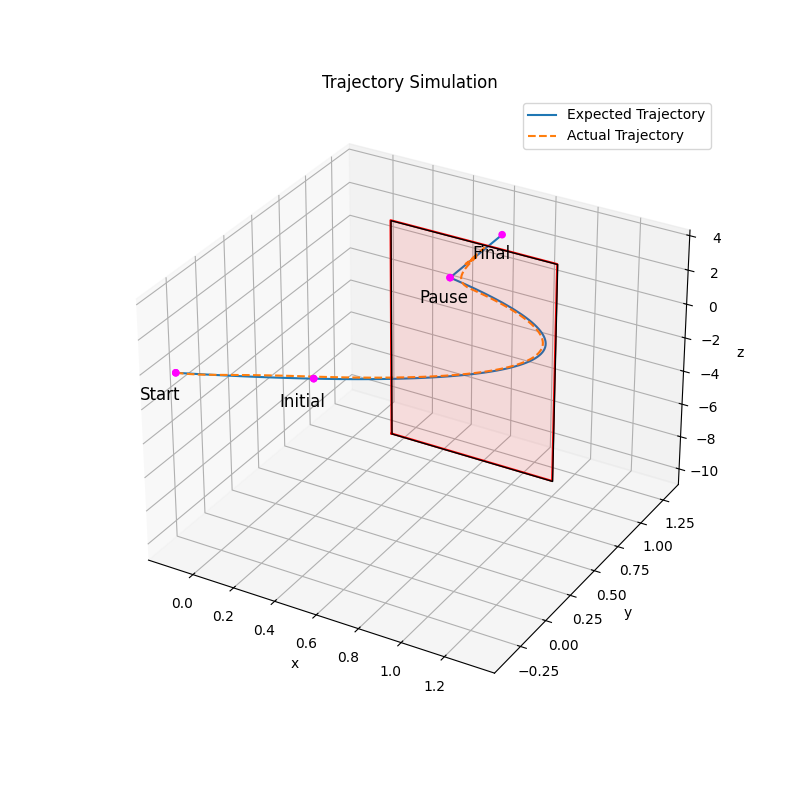

In [70]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")

#traj = f_traj(ts)
#traj = f_linear_3d(ts_test)
traj = planned_traj
ax.plot(traj[:,0], traj[:,1], traj[:,2], label="Expected Trajectory")

actual_pos = np.vstack(x)
ax.plot(actual_pos[:,0], actual_pos[:,1], actual_pos[:,2] ,"--", label="Actual Trajectory")

ax.scatter(turns_pos[:,0], turns_pos[:,1], turns_pos[:,2], alpha=1, c="magenta")
ax.scatter(all_points[:,0], all_points[:,1], all_points[:,2], alpha=1, c="magenta")
ax.set_title("Trajectory Simulation")

ax.plot(xrec, yrec, zrec, color='r')
verts = [list(zip(xrec, yrec, zrec))]
faces = [[0, 1, 2, 3]]
poly3d = Poly3DCollection(verts, alpha=0.1, facecolor='r', linewidths=1, edgecolors='k')
ax.add_collection3d(poly3d)

for i, lbl in enumerate(["Start", "Initial", "Pause", "Final"]):
    #ax.text(turns_pos[i,0], turns_pos[i,1] - 0.3, turns_pos[i,2], lbl, fontsize=12)
    ax.text(all_points[i,0], all_points[i,1] - 0.3, all_points[i,2], lbl, fontsize=12)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.legend()
plt.show()
# ax.view_init(elev=30, azim=45)

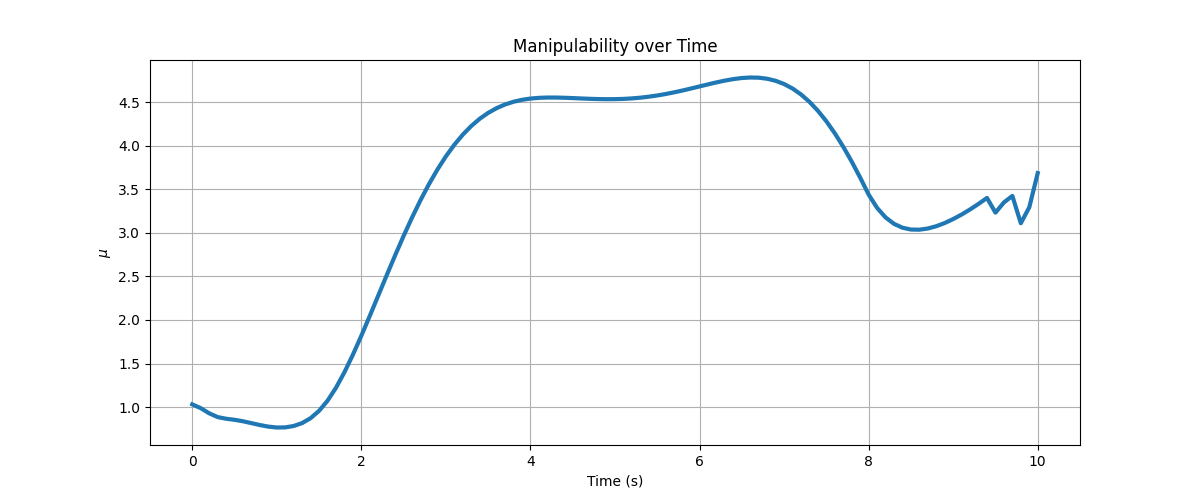

In [71]:
fig, ax = plt.subplots(figsize=(12,5))
ax.grid("True")
ax.set_title("Manipulability over Time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("$\mu$")
ax.plot(ts, mu, linewidth=3)

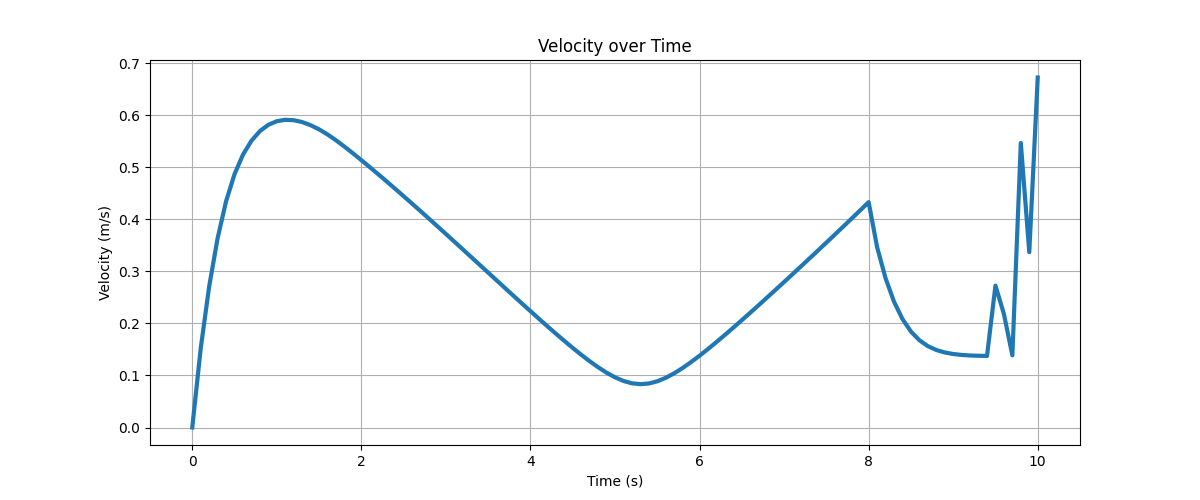

In [72]:
fig, ax = plt.subplots(figsize=(12,5))
ax.grid("True")
ax.set_title("Velocity over Time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity (m/s)")
ax.plot(ts, vel, linewidth=3)